In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch.utils.data as torch_data
import matplotlib.pyplot as plt
import collections
import torch.distributions as tdists
import math
import wandb
import matplotlib
from tabular_dataset import TabularDataset
import seaborn as sns

# Pre-processing aero data
import pandas as pd
from sklearn import preprocessing as skpp
from sklearn import model_selection as model



plt.rcParams.update({'font.size': 13})
plt.rc("axes", labelsize=18)
plt.rc("axes", titlesize=21)
plt.rc("legend", fontsize=18)

In [2]:
#import data
DATASET_PATH = './datasets'
DATASET_NAME = 'aero'
IMGS_PATH = './images'
dataset_dir = os.path.join(DATASET_PATH,DATASET_NAME)
assert os.path.exists(dataset_dir),("dataset folder {} does not exist".format(dataset_dir))

if not os.path.exists(IMGS_PATH):
    os.makedirs(IMGS_PATH)

splits = {}
LabelledData = collections.namedtuple("LabelledData",["x","y"])
#CHANGE DIMENSIONS OF DATA ACCORDINGLY
data_xdim = 3
data_ydim = 1
scatter_plot = 0

for split in ("train","test","val"):
    data_path = os.path.join(dataset_dir,"{}.csv".format(split))
    assert os.path.exists(data_path),"data file {} does not exist".format(data_path)
    
    data = np.genfromtxt(data_path,delimiter=",")
    if scatter_plot:
        plt.figure
        plt.scatter(data[:,:1],data[:,1:], c='k')
        plt.xlabel("x")
        plt.ylabel('y')
        plt.title(split)
        plt.show()
    torch_data = torch.tensor(data, device="cpu").float()
    splits[split] = LabelledData(x=torch_data[:,:data_xdim],y=torch_data[:,data_xdim:])

train_data = splits["train"]
val_data = splits['val']
test_data = splits['test']

In [3]:
train_tab = TabularDataset(train_data)
train_tab.xs[0]

tensor([-0.7698,  0.3584, -0.1038])

In [19]:
df_train = pd.read_csv("raw_data/aero/train/data_raw.dat", header = 0, index_col = 0)
aero_train = df_train[["URef", "PLExp", "IECturbc", "TwrBsMxt_[kN-m] ST_DEL"]]
aero_train_mean = aero_train.mean()
# aero_train_mean.head
aero_train_std = aero_train.std()

aero_train_scale = (aero_train - aero_train_mean)/aero_train_std
# aero_train_scale.tail()

aero_train_split, aero_val_split = model.train_test_split(aero_train_scale, test_size=0.3, random_state=42)
# np.savetxt("train.csv", aero_train_split,delimiter=",")
# np.savetxt("val.csv", aero_val_split,delimiter=",")

df_test = pd.read_csv("raw_data/aero/test/data_raw.dat", header = 0, index_col = 0)
# plt.figure()
# plt.scatter(df_test["URef"],df_test["TwrBsMxt_[kN-m] ST_DEL"])

In [4]:
#create NN classes for discrimator/generator
def ffsection(x_dim, other_dim, layer_list, extra_in_hidden_dim=0):
    if not layer_list:
        layers = []
        out_dim = x_dim+extra_in_hidden_dim
    else:
        layers = [nn.Linear(x_dim + other_dim, layer_list[0])]+\
            [nn.Linear(from_dim+extra_in_hidden_dim, to_dim) \
            for from_dim, to_dim in zip(layer_list[:-1], layer_list[1:])]
    out_dim = layer_list[-1]
    return nn.ModuleList(layers), out_dim

class NoiseInjection(nn.Module):
    def __init__(self, nn_spec) -> None:
        super().__init__()
        self.activation = nn_spec["activation"]#relu
        self.nodes_per_layer = nn_spec["nodes_per_layer"]#[64, 64, 64, 64, 64, 64]
        self.other_dim = nn_spec["other_dim"]#5,#noise dimensions
        self.cond_dim = nn_spec["cond_dim"]# 1 #data_xdim
        self.output_dim = nn_spec["output_dim"]#1 #data_ydim

        self.layers, self.last_layer_dim = ffsection(
            self.cond_dim, self.other_dim, self.nodes_per_layer, self.other_dim)
        self.output_layer = nn.Linear((self.last_layer_dim+self.other_dim),self.output_dim)
        
    def forward(self, x):
        hidden_repr = x[:,:self.cond_dim]
        noise = x[:,self.cond_dim:]
        for layer in self.layers:
            combined_repr = torch.cat((hidden_repr, noise), dim = 1)
            hidden_repr = self.activation(layer(combined_repr))
        
        hidden_repr = torch.cat((hidden_repr, noise),dim =1)    
        return self.output_layer(hidden_repr)
class FeedForward(nn.Module):
    def __init__(self, nn_spec) -> None:
        super().__init__()
        self.activation = nn_spec["activation"]
        self.nodes_per_layer = nn_spec["nodes_per_layer"]
        self.other_dim = nn_spec["other_dim"]
        self.cond_dim = nn_spec["cond_dim"]
        self.output_dim = nn_spec["output_dim"]

        self.layers, self.last_layer_dim = ffsection(
            self.cond_dim, self.other_dim, self.nodes_per_layer)
        self.output_layer = nn.Linear(self.last_layer_dim,self.output_dim)
    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))
        return self.output_layer(x)#no activation fnc before output

class DoubleInputNetwork(nn.Module):
    def __init__(self, nn_spec) -> None:
        super().__init__()

        self.activation = nn_spec["activation"]
        self.dim_x = nn_spec["cond_dim"]
        
        self.cond_layers, cond_dim = ffsection(nn_spec["cond_dim"], other_dim= 0,
                                               layer_list= nn_spec["cond_layers"])
        self.other_layers, other_dim = ffsection(x_dim = 0,other_dim = nn_spec["other_dim"],
                                                 layer_list=nn_spec["other_layers"])
        self.hidden_layers, hidden_dim = ffsection(cond_dim, other_dim,
                                                    nn_spec["nodes_per_layer"])
        self.output_layer = nn.Linear(hidden_dim, nn_spec["output_dim"])

    def forward(self, x):
        cond_repr = x[:,:self.dim_x]
        other_repr = x[:,self.dim_x:]

        #conditional input
        for layer in self.cond_layers:
            cond_repr = self.activation(layer(cond_repr))
        #other (noise/real data)
        for layer in self.other_layers:
            other_repr = self.activation(layer(other_repr))
        
        hidden_input = torch.cat((cond_repr, other_repr), dim = 1)
        for layer in self.hidden_layers:
            hidden_input = self.activation(layer(hidden_input))

        output = self.output_layer(hidden_input)
        return output


In [73]:
class CGAN:
    def __init__(self, config, nn_spec) -> None:
        self.device = "cuda" if torch.cuda.is_available() else "cpu" 
        self.bce_logits = nn.BCEWithLogitsLoss(reduction="mean")
        self.disc = nn_spec['disc_spec']['type'](nn_spec['disc_spec']).to(self.device)
        self.gen = nn_spec['gen_spec']['type'](nn_spec['gen_spec']).to(self.device)
        self.config = config
        self.kernel_scale = None
        self.val_ll = []
        self.train_ll = []
        self.epoch_ll = []
        self.nn_spec = nn_spec

    def train(self, train_data, val_func):
        train_tab = TabularDataset(train_data)
        n_samples = len(train_tab)
        train_loader = torch.utils.data.DataLoader(train_tab,
                                                    batch_size = config["num_batches"],
                                                    shuffle = True,
                                                    num_workers = 4)
        self.gen.train()
        self.disc.train()

        best_11 = None #best validation log-likelihood
        best_mae = None
        best_epoch_i = None
        val_ll = []
        train_ll = []
        epoch_ll = []
        best_save_path = os.path.join("./",
                            "epoch_best.pt") # Path to save best params to

        gen_opt = torch.optim.RMSprop(self.gen.parameters(),lr = config["gen_lr"])
        disc_opt = torch.optim.RMSprop(self.disc.parameters(), lr = config["disc_lr"])
        for epoch in range(self.config["epochs"]):
            epoch_disc_loss = []
            epoch_gen_loss = []
            epoch_fooling = []
            for n_batch, (x_batch, data_batch) in enumerate(train_loader):
                batch_size = data_batch.shape[0]

                x_batch = x_batch.to(self.device)
                data_batch = data_batch.to(self.device)

                disc_opt.zero_grad()

                noise_batch = self.get_gaussian().sample([batch_size]).to(self.device)
                
                #Sample from generator
                gen_input = torch.cat((x_batch, noise_batch), dim = 1)
                gen_output = self.gen(gen_input)
                #Train discriminator
                data_logits = self.disc(torch.cat((x_batch, data_batch), dim = 1))
                gen_logits = self.disc(torch.cat((x_batch,gen_output), dim = 1))
                disc_loss = self.disc_loss(gen_logits, data_logits)
                disc_loss.backward()
                disc_opt.step()

                #train generator
                gen_opt.zero_grad()
                n_gen_samples = batch_size
                new_noise_batch = self.get_gaussian().sample([n_gen_samples]).to(self.device)

                new_gen_input = torch.cat((x_batch,new_noise_batch),dim = 1)
                new_gen_batch = self.gen(new_gen_input)
                new_gen_logits = self.disc(torch.cat((x_batch,new_gen_batch),dim = 1))
                gen_loss = self.gen_loss(new_gen_logits) 
                gen_loss.backward()
                gen_opt.step()

                batch_fooling = torch.mean(torch.sigmoid(new_gen_logits))
                epoch_fooling.append(batch_fooling.item())
                epoch_disc_loss.append(disc_loss.item())
                epoch_gen_loss.append(gen_loss.item())

            if val_func and ((epoch+1) % self.config["val_interval"] == 0):
                evaluation_vals, evaluation_vals_train = val_func(self, epoch)
                tmp = evaluation_vals["ll"]
                tmp2 = evaluation_vals_train["ll"]
                val_ll.append(tmp)                
                train_ll.append(tmp2)
                epoch_ll.append(epoch+1)
                if (best_epoch_i==None) or evaluation_vals["ll"] > best_ll:
                    best_ll = evaluation_vals["ll"]
                    best_mae = evaluation_vals["mae"]
                    best_epoch_i = epoch
                    model_params = {
                        "gen": self.gen.state_dict(),
                        "disc": self.disc.state_dict(),
                    }
                    torch.save(model_params, best_save_path)
        
        self.val_ll = val_ll
        self.train_ll = train_ll
        self.epoch_ll = epoch_ll
        plt.figure()
        plt.plot(epoch_ll,val_ll, label = "val ll")
        plt.plot(epoch_ll,train_ll, label = "train ll")
        plt.title("history")
        plt.legend()
        images_save_path = os.path.join(IMGS_PATH,"./history.png")
        plt.savefig(images_save_path)
        
        print("best ll:%g",best_ll)
        print("best mae:%g",best_mae)
        print("best epoch:%g",best_epoch_i)
        checkpoint = torch.load(best_save_path, map_location=self.device)
        self.disc.load_state_dict(checkpoint["disc"])
        if "gen" in checkpoint:
            self.gen.load_state_dict(checkpoint["gen"])
        
    def gen_loss(self, gen_logits):
        return self.bce_logits(gen_logits, torch.ones_like(gen_logits))
    def disc_loss(self, gen_logits, data_logits):
        return self.bce_logits(gen_logits,torch.zeros_like(gen_logits))+\
            self.bce_logits(data_logits, torch.ones_like(data_logits))
    def get_gaussian(self):
        return tdists.multivariate_normal.MultivariateNormal(
                torch.zeros(self.config["noise_dim"], device=self.device),
                torch.eye(self.config["noise_dim"], device=self.device)
            ) #isotropic 

    @torch.no_grad()
    def eval(self, dataset, kde_eval, use_best_kernel_scale=False):
        ks = None

        if use_best_kernel_scale:
            assert self.kernel_scale, "No kernel scale stored in class CGAN"
            ks = self.kernel_scale
        evaluation_vals, best_kernel_scale = kde_eval(self, dataset, kernel_scale = ks)
        self.kernel_scale = best_kernel_scale
        return evaluation_vals

    @torch.no_grad()
    def sample(self, x, batch_size = None, fixed_noise=False):
        n_samples = x.shape[0]
        x = x.to(self.device)

        noise_sample = self.get_gaussian().sample([n_samples]).to(self.device)

        if batch_size and n_samples > batch_size:
            batch_iterator = zip(torch.split(x, batch_size,dim=0),
                                 torch.split(noise_sample, batch_size, dim=0))
            sample_list = []
            for x_batch, noise_batch in batch_iterator:
                gen_input = torch.cat((x_batch, noise_batch), dim = 1)
                sample_batch = self.gen(gen_input)
                sample_list.append(sample_batch)
            samples = torch.cat(sample_list, dim = 0)
        else:
            gen_input = torch.cat((x,noise_sample), dim = 1)
            samples = self.gen(gen_input)
        return samples


In [97]:
class PearsonCGAN(CGAN):
    def disc_loss(self, gen_logits, data_logits):
        return torch.mean(-1.*data_logits) +\
            torch.mean(gen_logits*(0.25*gen_logits + 1.0))
    def gen_loss(self, gen_logits):
        return torch.mean(-1*gen_logits)
class LSCGAN(CGAN):
    def disc_loss(self, gen_logits, data_logits):
        return 0.5*(nn.functional.mse_loss(data_logits, torch.ones_like(data_logits))
                + nn.functional.mse_loss(gen_logits, torch.zeros_like(gen_logits)))

    def gen_loss(self, gen_logits):
        return 0.5*nn.functional.mse_loss(gen_logits, torch.ones_like(gen_logits))

In [75]:
def evaluate_model(model, data, data_train, epoch=None, make_plots = True):
    testing = (epoch==None) #returns False/0 if epoch is not None
    config = model.config
    evaluation_vals = model.eval(data, kde_eval, use_best_kernel_scale=testing)
    val_method = "true"
    metric_string = "\t".join(["{}: {:.5}".format(key, validation_val) for
        (key,validation_val) in evaluation_vals.items()])
    print("Epoch {}, {}\t{}".format(epoch, val_method, metric_string))

    tmp = data.x.shape[0]
    data_train_partial = LabelledData(x=data_train.x[:tmp], y=data_train.y[:tmp])
    evaluation_vals_train = model.eval(data_train_partial, kde_eval, use_best_kernel_scale = testing)
    metric_string = "\t".join(["{}: {:.5}".format(key, training_val) for
        (key,training_val) in evaluation_vals_train.items()])
    print("Training Epoch {}, {}\t{}".format(epoch, val_method, metric_string))
    
    if make_plots:
        if config["scatter"]:
            model_samples = model.sample(data.x, batch_size = config["eval_batch_size"])
            if type(model_samples) == torch.Tensor:
                model_samples = model_samples.to("cpu")
            model_data = LabelledData(x=data.x, y = model_samples)
            plot_title = 'Training epoch {}'.format(epoch)
            sample_sets = [data, model_data]
            labels = ["Ground Truth", "model"]
            plot_samples(sample_sets, file_name = epoch,
                        labels = labels, title=plot_title, range_dataset=data)
                      
    return evaluation_vals, evaluation_vals_train 

def mae_from_samples(samples, y):
    medians,_ = torch.median(samples, dim=1)
    abs_errors = torch.sum(torch.abs(medians-y), dim = 1)
    return torch.mean(abs_errors).item()

def kde_eval(model, data, kernel_scale=None):
    x = data.x.to(model.device)
    x_repeated = torch.repeat_interleave(x, repeats = model.config["eval_samples"], dim = 0)
    shape_y = data.y.shape
    samples = model.sample(x_repeated, batch_size = model.config["eval_batch_size"]).reshape(
        shape_y[0],model.config["eval_samples"],shape_y[1])
    y = data.y.to(model.device)
    diff = samples - y.unsqueeze(1)
    squarednorm = torch.sum(torch.pow(diff,2), dim = 2)

    if not (kernel_scale == None):
        n_h = 1
        h_squared = torch.tensor([kernel_scale], device = model.device)
    else:
        n_h = model.config["kernel_scales"]
        h_squared = torch.logspace(
            math.log10(model.config["kernel_scale_min"]),
            math.log10(model.config["kernel_scale_max"]), steps = n_h)
    h_squared = h_squared.to(model.device)
    scale_lls = []
    #Batch over kernel scales
    h_squared_splits = torch.split(h_squared, model.config["kde_batch_size"], dim = 0)

    for splits in h_squared_splits:
        normalisation = torch.pow(torch.rsqrt(2.*math.pi*splits), data_ydim)
        ratio = squarednorm.unsqueeze(dim=2).repeat((1,1,splits.shape[0]))/splits

        ll_y = torch.log(normalisation)+torch.logsumexp(-0.5*(ratio), dim = 1)-\
                math.log(model.config["eval_samples"])
        mean_lls = torch.mean(ll_y, dim = 0)
        scale_lls.append(mean_lls)
    joined_scale_lls = torch.cat(scale_lls, dim = 0)

    argmax = torch.argmax(joined_scale_lls)
    best_scale = h_squared[argmax]
    
    best_ll = joined_scale_lls[argmax].item()
    best_mae = mae_from_samples(samples, y)
    evaluation_vals = {
        "ll": best_ll,
        "mae": best_mae
    }

    return evaluation_vals, best_scale

def val_func(model, epoch):
    return evaluate_model(model, data = val_data, data_train=train_data, epoch = epoch)

def plot_samples(sample_sets, file_name, labels=None, range_dataset=None,
        title=None, both_y=False):
    n_sets = len(sample_sets)
    fig, axes = plt.subplots(nrows=1, ncols=n_sets, squeeze=False,
            figsize=(7.*n_sets, 4.5))
    x_range = (min(range_dataset.x), max(range_dataset.x))
    y_range = (min(range_dataset.y), max(range_dataset.y))
    for set_i, (samples, ax) in enumerate(zip(sample_sets, axes[0])):
        ax.scatter(samples.x, samples.y, s=3, color="green")
    
        ax.set_xlim(*x_range)
        ax.set_ylim(*y_range)

        if labels:
            ax.set(title=labels[set_i])
        if both_y:
            ax.set(xlabel="$y_1$", ylabel="$y_2$")
        else:
            ax.set(xlabel="$x$", ylabel="$y$")
    if title:
        fig.suptitle(title)

    fig.tight_layout()
    plot_path = os.path.join(IMGS_PATH,"{}.png".format(file_name))
    plt.savefig(plot_path)
    plt.close(fig)


In [76]:
#get samples from trained model
def get_samples(model,input):
    input = torch.tensor(input, dtype = torch.float)
    input_repeated = input.repeat(1000,1)
    samples = model.sample(input_repeated, batch_size = 1000)    
    return samples.cpu()

Epoch 49, true	ll: -0.88235	mae: 0.39285
Training Epoch 49, true	ll: -0.87731	mae: 0.38854
Epoch 99, true	ll: -0.48621	mae: 0.35625
Training Epoch 99, true	ll: -0.63201	mae: 0.35669
Epoch 149, true	ll: -0.53947	mae: 0.36909
Training Epoch 149, true	ll: -0.60968	mae: 0.37916
Epoch 199, true	ll: -0.36519	mae: 0.30623
Training Epoch 199, true	ll: -0.50571	mae: 0.30391
Epoch 249, true	ll: -0.15733	mae: 0.28391
Training Epoch 249, true	ll: -0.38718	mae: 0.2878
Epoch 299, true	ll: -0.16006	mae: 0.28788
Training Epoch 299, true	ll: -0.29924	mae: 0.29032
Epoch 349, true	ll: -0.11165	mae: 0.27932
Training Epoch 349, true	ll: -0.29071	mae: 0.28361
Epoch 399, true	ll: -0.12144	mae: 0.28138
Training Epoch 399, true	ll: -0.32303	mae: 0.28265
Epoch 449, true	ll: -0.093673	mae: 0.27786
Training Epoch 449, true	ll: -0.25304	mae: 0.28156
Epoch 499, true	ll: -0.064968	mae: 0.27523
Training Epoch 499, true	ll: -0.19598	mae: 0.27533
Epoch 549, true	ll: -0.10388	mae: 0.28111
Training Epoch 549, true	ll: -0

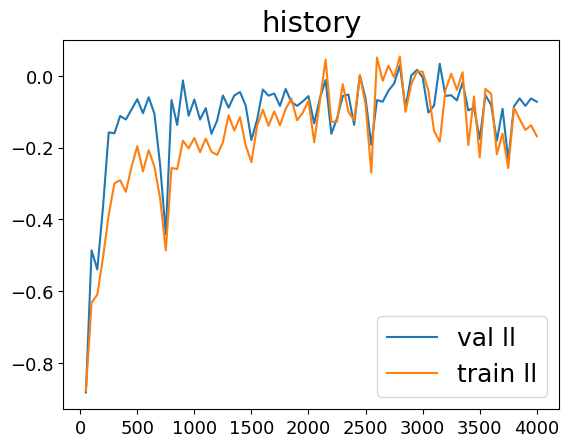

In [77]:
#create nn spec for discriminator and generator
config = {
    "noise_dim": 10,
    "epochs": 4000,
    "num_batches": 200,
    "gen_lr": 1e-4,
    "disc_lr": 1e-4,
    "val_interval": 50,
    "eval_batch_size": 1000,
    "eval_samples": 200,
    "kernel_scales": 50,
    "kernel_scale_min": 0.001,
    "kernel_scale_max": 0.5,
    "scatter": 0,
    "kde_batch_size": 10,
    "plot_pdf_index": "645"  
}
nn_spec = {'gen_spec' : {
    "other_dim": config["noise_dim"],#noise dimensions
    "cond_dim": data_xdim,#conditioning data
    "nodes_per_layer": [64, 64, 64, 64, 64, 64],
    "output_dim": data_ydim,#fake data dimensions
    "activation": F.relu,
    "type": NoiseInjection
},
'disc_spec': {
    "other_dim": data_ydim,#actual data dimensions
    "cond_dim": data_xdim,
    "nodes_per_layer": [64, 64, 64, 64, 64, 64],
    "cond_layers": [64,64],
    "other_layers":[64,64],
    "output_dim": 1,#output logit
    "activation": F.relu,
    "type": DoubleInputNetwork
}
}
cgan_model = PearsonCGAN(config, nn_spec)
cgan_model.train(train_data,val_func)

Epoch 49, true	ll: -0.99767	mae: 0.48497
Training Epoch 49, true	ll: -1.0034	mae: 0.49106
Epoch 99, true	ll: -0.63902	mae: 0.38265
Training Epoch 99, true	ll: -0.75016	mae: 0.3941
Epoch 149, true	ll: -0.52991	mae: 0.37224
Training Epoch 149, true	ll: -0.68353	mae: 0.38471
Epoch 199, true	ll: -0.48816	mae: 0.36452
Training Epoch 199, true	ll: -0.6795	mae: 0.36545
Epoch 249, true	ll: -0.40555	mae: 0.34853
Training Epoch 249, true	ll: -0.59308	mae: 0.35633
Epoch 299, true	ll: -0.40882	mae: 0.36428
Training Epoch 299, true	ll: -0.56356	mae: 0.37517
Epoch 349, true	ll: -0.38371	mae: 0.35626
Training Epoch 349, true	ll: -0.59659	mae: 0.36373
Epoch 399, true	ll: -0.35177	mae: 0.34813
Training Epoch 399, true	ll: -0.60468	mae: 0.35294
Epoch 449, true	ll: -0.33268	mae: 0.34172
Training Epoch 449, true	ll: -0.53902	mae: 0.34376
Epoch 499, true	ll: -0.32115	mae: 0.33845
Training Epoch 499, true	ll: -0.56386	mae: 0.34134
Epoch 549, true	ll: -0.43385	mae: 0.35402
Training Epoch 549, true	ll: -0.531

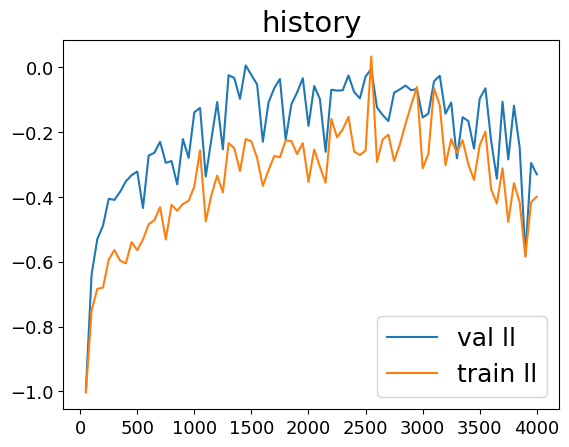

In [78]:
config = {
    "noise_dim": 30,
    "epochs": 4000,
    "num_batches": 200,
    "gen_lr": 1e-4,
    "disc_lr": 1e-4,
    "val_interval": 50,
    "eval_batch_size": 1000,
    "eval_samples": 200,
    "kernel_scales": 50,
    "kernel_scale_min": 0.001,
    "kernel_scale_max": 0.5,
    "scatter": 0,
    "kde_batch_size": 10,
    "plot_pdf_index": "645"  
}
nn_spec = {'gen_spec' : {
    "other_dim": config["noise_dim"],#noise dimensions
    "cond_dim": data_xdim,#conditioning data
    "nodes_per_layer": [64, 64, 64, 64, 64, 64],
    "output_dim": data_ydim,#fake data dimensions
    "activation": F.relu,
    "type": NoiseInjection
},
'disc_spec': {
    "other_dim": data_ydim,#actual data dimensions
    "cond_dim": data_xdim,
    "nodes_per_layer": [64, 64, 64, 64, 64, 64],
    "cond_layers": [64,64],
    "other_layers":[64,64],
    "output_dim": 1,#output logit
    "activation": F.relu,
    "type": DoubleInputNetwork
}
}
cgan_model_noise_30 = PearsonCGAN(config, nn_spec)
cgan_model_noise_30.train(train_data,val_func)

Text(0, 0.5, 'Validation ll')

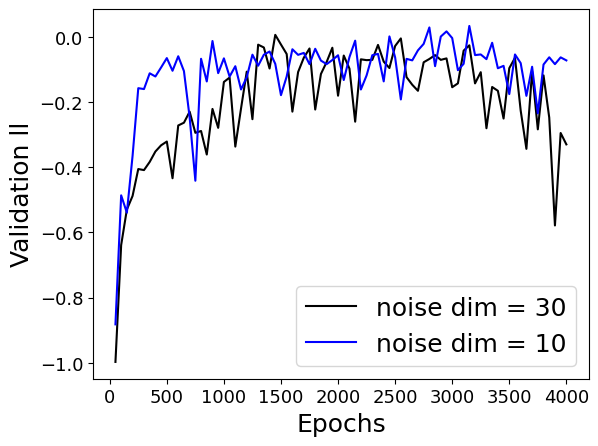

In [79]:
plt.figure()
plt.plot(cgan_model_noise_30.epoch_ll,cgan_model_noise_30.val_ll, color ='k', label='noise dim = 30')
plt.plot(cgan_model.epoch_ll, cgan_model.val_ll, color = 'b', label = 'noise dim = 10')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation ll')

Text(0.5, 1.0, 'noise dim 10')

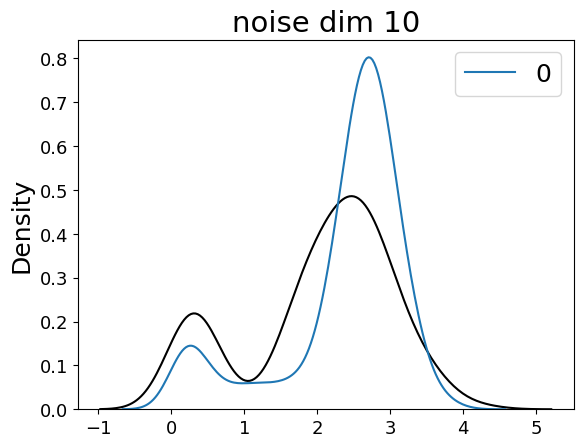

In [93]:
aero_test = df_test.loc[:, ["URef", "PLExp", "IECturbc", "TwrBsMxt_[kN-m] ST_DEL"]]
aero_test_scale = (aero_test-aero_train_mean)/aero_train_std
aero_test_scale.head()
# np.savetxt("test.csv", aero_test_scale,delimiter=",")
# tmp = np.genfromtxt("test.csv", delimiter = ",")

test = LabelledData(x= aero_test_scale.to_numpy()[:,:3],y = aero_test_scale.to_numpy()[:,3:])

idx_values = test.x[645]
# 645,

#obtain indexes of similar "x" 
indexes = []
for idx in range(len(test.x)):
    if (test.x[idx] == idx_values).all():
        indexes.append(idx)

test_filtered = test.y[indexes]
gen_samples = get_samples(cgan_model , idx_values)
gen_samples_nd_30 = get_samples(cgan_model_noise_30 , idx_values)
plt.figure()
sns.kdeplot(test_filtered.squeeze(1), color = 'k', legend=False)
sns.kdeplot(gen_samples, color='b')
# sns.kdeplot(gen_samples_nd_30, color = 'r')
plt.title('noise dim 10')
# plt.legend('10')


Epoch 49, true	ll: -1.3283	mae: 0.66837
Training Epoch 49, true	ll: -1.3164	mae: 0.64721
Epoch 99, true	ll: -1.1484	mae: 0.59006
Training Epoch 99, true	ll: -1.14	mae: 0.59116
Epoch 149, true	ll: -1.0461	mae: 0.51903
Training Epoch 149, true	ll: -1.0433	mae: 0.5172
Epoch 199, true	ll: -0.79094	mae: 0.46567
Training Epoch 199, true	ll: -0.85877	mae: 0.47686
Epoch 249, true	ll: -0.63895	mae: 0.41865
Training Epoch 249, true	ll: -0.73278	mae: 0.41769
Epoch 299, true	ll: -0.40282	mae: 0.32122
Training Epoch 299, true	ll: -0.52919	mae: 0.32403
Epoch 349, true	ll: -0.34951	mae: 0.31179
Training Epoch 349, true	ll: -0.44998	mae: 0.31183
Epoch 399, true	ll: -0.26714	mae: 0.30325
Training Epoch 399, true	ll: -0.35484	mae: 0.30026
Epoch 449, true	ll: -0.25259	mae: 0.30105
Training Epoch 449, true	ll: -0.3247	mae: 0.29825
Epoch 499, true	ll: -0.21319	mae: 0.29948
Training Epoch 499, true	ll: -0.34305	mae: 0.29639
Epoch 549, true	ll: -0.30201	mae: 0.31811
Training Epoch 549, true	ll: -0.41274	mae:

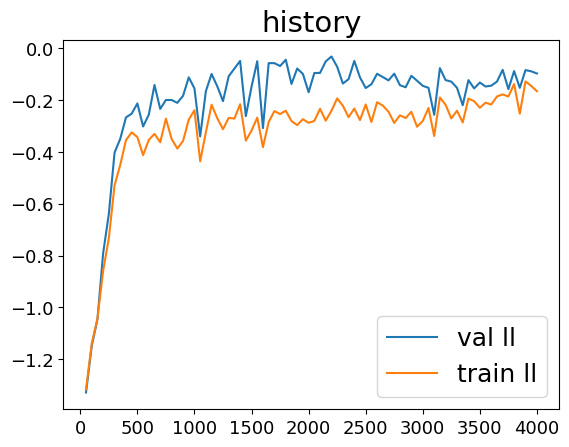

In [89]:
config = {
    "noise_dim": 10,
    "epochs": 4000,
    "num_batches": 200,
    "gen_lr": 1e-4,
    "disc_lr": 1e-4,
    "val_interval": 50,
    "eval_batch_size": 1000,
    "eval_samples": 200,
    "kernel_scales": 50,
    "kernel_scale_min": 0.001,
    "kernel_scale_max": 0.5,
    "scatter": 0,
    "kde_batch_size": 10,
    "plot_pdf_index": "645"  
}
nn_spec = {'gen_spec' : {
    "other_dim": config["noise_dim"],#noise dimensions
    "cond_dim": data_xdim,#conditioning data
    "nodes_per_layer": [16, 16, 16, 16, 16],
    "output_dim": data_ydim,#fake data dimensions
    "activation": F.relu,
    "type": NoiseInjection
},
'disc_spec': {
    "other_dim": data_ydim,#actual data dimensions
    "cond_dim": data_xdim,
    "nodes_per_layer": [16, 16, 16],
    "cond_layers": [16],
    "other_layers":[16],
    "output_dim": 1,#output logit
    "activation": F.relu,
    "type": DoubleInputNetwork
}
}
cgan_model_small_NI = PearsonCGAN(config, nn_spec)
cgan_model_small_NI.train(train_data,val_func)

Text(0, 0.5, 'Validation ll')

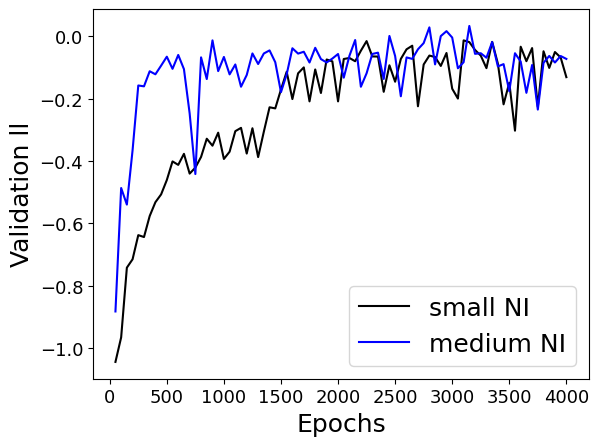

In [82]:
plt.figure()
plt.plot(cgan_model_small_NI.epoch_ll,cgan_model_small_NI.val_ll, color ='k', label='small NI')
plt.plot(cgan_model.epoch_ll, cgan_model.val_ll, color = 'b', label = 'medium NI')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation ll')

Text(0.5, 1.0, 'small NI')

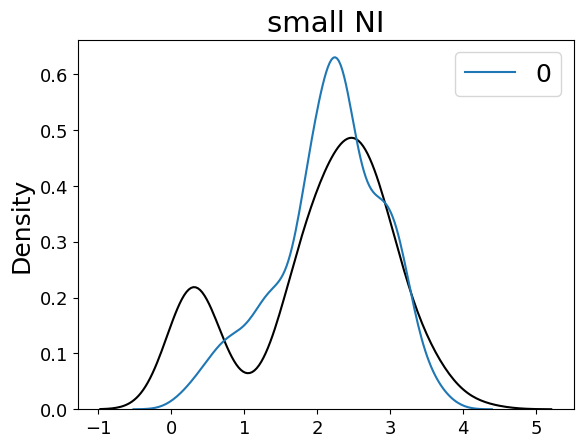

In [90]:
gen_samples_small_NI = get_samples(cgan_model_small_NI, idx_values)
# gen_samples = get_samples(cgan_model , idx_values)
plt.figure()
sns.kdeplot(test_filtered.squeeze(1), color = 'k', legend=False)
sns.kdeplot(gen_samples_small_NI, color='b')
# sns.kdeplot(gen_samples, color = 'r')
plt.title('small NI')
# plt.legend('10')


Epoch 49, true	ll: -0.77122	mae: 0.37981
Training Epoch 49, true	ll: -0.81236	mae: 0.38197
Epoch 99, true	ll: -0.49739	mae: 0.33439
Training Epoch 99, true	ll: -0.59821	mae: 0.33082
Epoch 149, true	ll: -0.35143	mae: 0.30418
Training Epoch 149, true	ll: -0.46646	mae: 0.30562
Epoch 199, true	ll: -0.25292	mae: 0.2853
Training Epoch 199, true	ll: -0.3999	mae: 0.28673
Epoch 249, true	ll: -0.15921	mae: 0.27949
Training Epoch 249, true	ll: -0.36249	mae: 0.28265
Epoch 299, true	ll: -0.14648	mae: 0.28335
Training Epoch 299, true	ll: -0.3162	mae: 0.28321
Epoch 349, true	ll: -0.15288	mae: 0.28378
Training Epoch 349, true	ll: -0.32573	mae: 0.28085
Epoch 399, true	ll: -0.13418	mae: 0.27408
Training Epoch 399, true	ll: -0.21808	mae: 0.27512
Epoch 449, true	ll: -0.10818	mae: 0.29369
Training Epoch 449, true	ll: -0.23393	mae: 0.30039
Epoch 499, true	ll: -0.054848	mae: 0.26676
Training Epoch 499, true	ll: -0.07584	mae: 0.26706
Epoch 549, true	ll: -0.046795	mae: 0.27273
Training Epoch 549, true	ll: -0.1

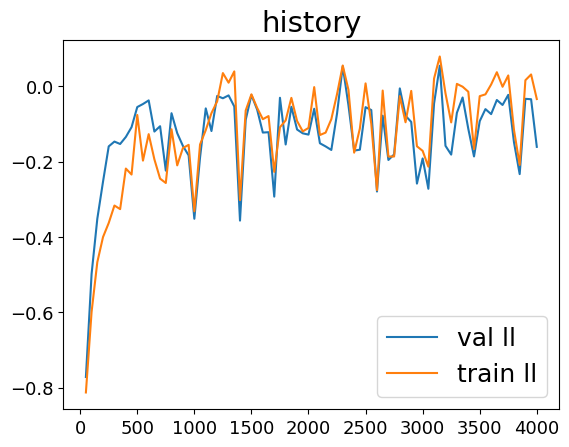

In [83]:
#create nn spec for discriminator and generator
config = {
    "noise_dim": 5,
    "epochs": 4000,
    "num_batches": 200,
    "gen_lr": 1e-4,
    "disc_lr": 1e-4,
    "val_interval": 50,
    "eval_batch_size": 1000,
    "eval_samples": 200,
    "kernel_scales": 50,
    "kernel_scale_min": 0.001,
    "kernel_scale_max": 0.5,
    "scatter": 0,
    "kde_batch_size": 10,
    "plot_pdf_index": "645"  
}
nn_spec = {'gen_spec' : {
    "other_dim": config["noise_dim"],#noise dimensions
    "cond_dim": data_xdim,#conditioning data
    "nodes_per_layer": [64, 64, 64, 64, 64, 64],
    "output_dim": data_ydim,#fake data dimensions
    "activation": F.relu,
    "type": NoiseInjection
},
'disc_spec': {
    "other_dim": data_ydim,#actual data dimensions
    "cond_dim": data_xdim,
    "nodes_per_layer": [64, 64, 64, 64, 64, 64],
    "cond_layers": [64,64],
    "other_layers":[64,64],
    "output_dim": 1,#output logit
    "activation": F.relu,
    "type": DoubleInputNetwork
}
}
cgan_model_noise_5 = PearsonCGAN(config, nn_spec)
cgan_model_noise_5.train(train_data,val_func)

<AxesSubplot:ylabel='Density'>

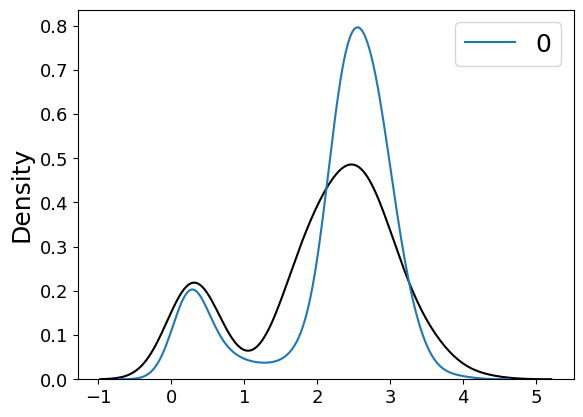

In [88]:
get_samples_noise_5 = get_samples(cgan_model_noise_5, idx_values)
plt.figure()
sns.kdeplot(test_filtered.squeeze(1), color = 'k', legend=False)
sns.kdeplot(get_samples_noise_5)

Epoch 49, true	ll: -0.79258	mae: 0.36307
Training Epoch 49, true	ll: -0.78627	mae: 0.36369
Epoch 99, true	ll: -0.61469	mae: 0.35595
Training Epoch 99, true	ll: -0.7313	mae: 0.35763
Epoch 149, true	ll: -0.60161	mae: 0.34281
Training Epoch 149, true	ll: -0.69913	mae: 0.34195
Epoch 199, true	ll: -0.49001	mae: 0.31494
Training Epoch 199, true	ll: -0.59616	mae: 0.31783
Epoch 249, true	ll: -0.30308	mae: 0.29124
Training Epoch 249, true	ll: -0.3972	mae: 0.29051
Epoch 299, true	ll: -0.23465	mae: 0.30393
Training Epoch 299, true	ll: -0.34352	mae: 0.30306
Epoch 349, true	ll: -0.12741	mae: 0.27552
Training Epoch 349, true	ll: -0.29349	mae: 0.27626
Epoch 399, true	ll: -0.11067	mae: 0.27823
Training Epoch 399, true	ll: -0.22908	mae: 0.27871
Epoch 449, true	ll: -0.069748	mae: 0.27828
Training Epoch 449, true	ll: -0.18627	mae: 0.27771
Epoch 499, true	ll: -0.40702	mae: 0.33983
Training Epoch 499, true	ll: -0.43617	mae: 0.33861
Epoch 549, true	ll: -0.020545	mae: 0.26957
Training Epoch 549, true	ll: -0.

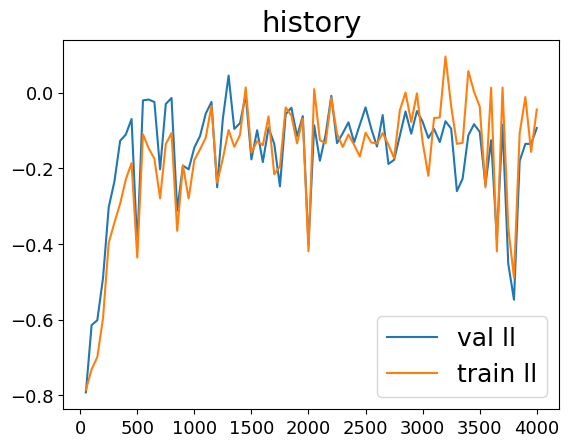

In [94]:
#create nn spec for discriminator and generator
config = {
    "noise_dim": 10,
    "epochs": 4000,
    "num_batches": 200,
    "gen_lr": 1e-4,
    "disc_lr": 1e-4,
    "val_interval": 50,
    "eval_batch_size": 1000,
    "eval_samples": 200,
    "kernel_scales": 50,
    "kernel_scale_min": 0.001,
    "kernel_scale_max": 0.5,
    "scatter": 0,
    "kde_batch_size": 10,
    "plot_pdf_index": "645"  
}
nn_spec = {'gen_spec' : {
    "other_dim": config["noise_dim"],#noise dimensions
    "cond_dim": data_xdim,#conditioning data
    "nodes_per_layer": [64, 64, 64, 64, 64, 64],
    "output_dim": data_ydim,#fake data dimensions
    "activation": F.relu,
    "type": NoiseInjection
},
'disc_spec': {
    "other_dim": data_ydim,#actual data dimensions
    "cond_dim": data_xdim,
    "nodes_per_layer": [64, 64, 64, 64, 64, 64],
    "cond_layers": [64,64],
    "other_layers":[64,64],
    "output_dim": 1,#output logit
    "activation": F.relu,
    "type": FeedForward
}
}
cgan_model_ff = PearsonCGAN(config, nn_spec)
cgan_model_ff.train(train_data,val_func)

<AxesSubplot:ylabel='Density'>

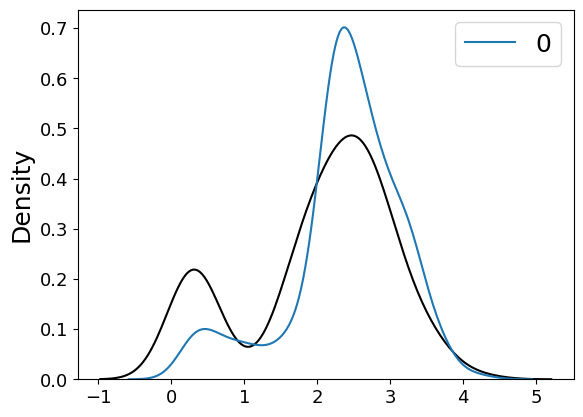

In [95]:
get_samples_ff = get_samples(cgan_model_ff, idx_values)
plt.figure()
sns.kdeplot(test_filtered.squeeze(1), color = 'k', legend=False)
sns.kdeplot(get_samples_ff)

Epoch 49, true	ll: -0.78914	mae: 0.37535
Training Epoch 49, true	ll: -0.79124	mae: 0.3725
Epoch 99, true	ll: -0.80677	mae: 0.42785
Training Epoch 99, true	ll: -0.83016	mae: 0.41595
Epoch 149, true	ll: -0.5878	mae: 0.34421
Training Epoch 149, true	ll: -0.66968	mae: 0.3492
Epoch 199, true	ll: -0.44805	mae: 0.31239
Training Epoch 199, true	ll: -0.56912	mae: 0.31521
Epoch 249, true	ll: -0.32076	mae: 0.2946
Training Epoch 249, true	ll: -0.49295	mae: 0.29464
Epoch 299, true	ll: -0.21901	mae: 0.28595
Training Epoch 299, true	ll: -0.38053	mae: 0.28986
Epoch 349, true	ll: -0.18673	mae: 0.28452
Training Epoch 349, true	ll: -0.37083	mae: 0.28927
Epoch 399, true	ll: -0.24716	mae: 0.29094
Training Epoch 399, true	ll: -0.39596	mae: 0.29654
Epoch 449, true	ll: -0.21406	mae: 0.28631
Training Epoch 449, true	ll: -0.36637	mae: 0.29258
Epoch 499, true	ll: -0.18652	mae: 0.27723
Training Epoch 499, true	ll: -0.34113	mae: 0.28415
Epoch 549, true	ll: -0.20962	mae: 0.27037
Training Epoch 549, true	ll: -0.3284

<AxesSubplot:ylabel='Density'>

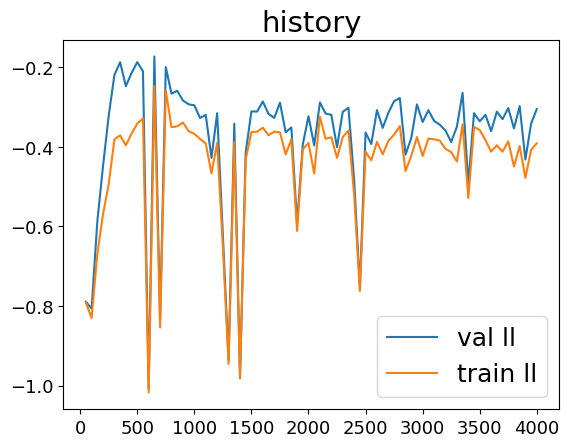

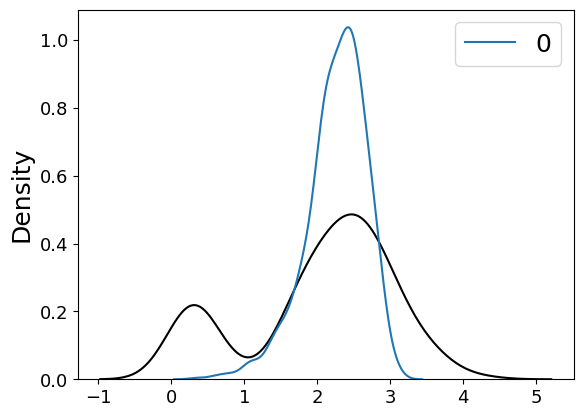

In [98]:
#create nn spec for discriminator and generator
config = {
    "noise_dim": 10,
    "epochs": 4000,
    "num_batches": 200,
    "gen_lr": 1e-4,
    "disc_lr": 1e-4,
    "val_interval": 50,
    "eval_batch_size": 1000,
    "eval_samples": 200,
    "kernel_scales": 50,
    "kernel_scale_min": 0.001,
    "kernel_scale_max": 0.5,
    "scatter": 0,
    "kde_batch_size": 10,
    "plot_pdf_index": "645"  
}
nn_spec = {'gen_spec' : {
    "other_dim": config["noise_dim"],#noise dimensions
    "cond_dim": data_xdim,#conditioning data
    "nodes_per_layer": [64, 64, 64, 64, 64, 64],
    "output_dim": data_ydim,#fake data dimensions
    "activation": F.relu,
    "type": NoiseInjection
},
'disc_spec': {
    "other_dim": data_ydim,#actual data dimensions
    "cond_dim": data_xdim,
    "nodes_per_layer": [64, 64, 64, 64, 64, 64],
    "cond_layers": [64,64],
    "other_layers":[64,64],
    "output_dim": 1,#output logit
    "activation": F.relu,
    "type": DoubleInputNetwork
}
}
cgan_model_LS = LSCGAN(config, nn_spec)
cgan_model_LS.train(train_data,val_func)
get_samples_LS = get_samples(cgan_model_LS, idx_values)
plt.figure()
sns.kdeplot(test_filtered.squeeze(1), color = 'k', legend=False)
sns.kdeplot(get_samples_LS)

In [79]:
def mean_func_heteroskedastic(x):
    return np.power(x,2)+0.5
def std_dev_heteroskedastic(x):
    return np.power(np.sin(np.pi*x), 2) + 0.01
def pdf_true_y_heteroskedastic(x):
    mean = mean_func_heteroskedastic(x)
    std_dev = std_dev_heteroskedastic(x)
    dist = torch.distributions.normal.Normal(mean, std_dev)
    return (lambda y: torch.exp(dist.log_prob(y)))
def get_supp(x):
    mean =  mean_func_heteroskedastic(x)
    std_dev = std_dev_heteroskedastic(x)
    return (mean-3*std_dev, mean+3*std_dev)

testx = torch.tensor([0.4])
testx_repeated= torch.repeat_interleave(testx, repeats = 5000, dim = 0).unsqueeze(dim=1)
testy = cgan_model.sample(testx_repeated,batch_size=1000)

# testy_pdf = pdf_true_y_heteroskedastic(0.4)
# x_real_support = get_supp(0.4) 
# xs_real = np.linspace(x_real_support[0], x_real_support[1], num=100)
# ys_real = testy_pdf(torch.tensor(xs_real))

# fig = plt.figure()
# ax = fig.add_subplot(111)
# line, = ax.plot(xs_real, ys_real, color = "k")
# g = sns.kdeplot(data=testy, legend = False, bw_adjust=1)
# # plt.legend(labels = ["true","sample"])
# ax.set_xlabel('x')
# plt.show()
# fig.savefig('pdf_plot')

# #samples 
# scatter_y = cgan_model.sample(test_data.x, batch_size=1000)
# scatter_test= plt.figure()
# scatter_ax = scatter_test.add_subplot(111)

# scatter_ax.scatter(test_data.x, scatter_y, s=3, color="green")
# scatter_ax.set_xlabel('x')
# scatter_ax.set_ylabel('y')
# plt.savefig('scatter_plot')

In [5]:
def get_pdf_wmix(x):
    # Perform pdf computation in pytorch
    
    n_comp = 2
    if type(x) == torch.Tensor:
        x = x.to("cpu")
    else:
        x = torch.tensor(x)

    comp_offsets = x[:n_comp]
    weights = x[n_comp:2*n_comp]
    comp_shape_mods = x[2*n_comp:]

    comp_probs = weights / torch.sum(weights)

    shapes = 1.0 + comp_shape_mods
    scales = torch.ones_like(shapes)

    w_dists = torch.distributions.weibull.Weibull(scales, shapes, validate_args = False)

    def pdf(y):
        no_offsets = y - 5.0*comp_offsets
        positive = (no_offsets >= 0)
        # Only use probability density for positive samples (within support)
        # Pytorch gives positive density even outside support for some reason

        log_probs = w_dists.log_prob(no_offsets)

        filtered_probs = torch.exp(log_probs[positive])
        pd = torch.sum(filtered_probs * comp_probs[positive])
        return pd

    return pdf

test_x = val_data.x[100]
# test_x = torch.Tensor([0.4])
print(test_x)

test_x_repeated = test_x.repeat(100,1)
test_y = cgan_model.sample(test_x_repeated)


out = get_pdf_wmix(test_x)
xs = np.linspace(0., 10., num=50)
pdf_ys = np.array([out(x) for x in xs])
plt.figure()
plt.plot(xs, pdf_ys, 'k-')
sns.kdeplot(test_y)

tensor([0.3712])


AttributeError: module sklearn.model_selection has no attribute sample